In [1]:
import os, glob, torch, torchvision, cv2, PIL, time, random
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# 5x: raw/flip/rotate/jitter/blur
# ResNet & VGG
CFG={'SEED' : 46,  # 42~46
     'IMG_SIZE' : 224,
     'AUGMENTATION' : 2,  # 1: ONLY flip / 2: 5가지 다
     'TEST_PORTION' : 0.5,  # Test set 비율
     'MODEL' : 3,  # 1: ResNet / 2: VGG / 3: Inception_v3
     'GLAND' : ".jpg",  # "PTG_" / "SMG_" / ".jpg"(PG+SG)
     'CONTROL' : "NON_SJS",  # "NORMAL" or "NON_SJS"
     'EPOCHS' : 30,
     'BATCH_SIZE' : 64,
     'LR' : 1e-4}

In [5]:
seed_everything(CFG["SEED"])

In [6]:
control = CFG["CONTROL"]
seed = CFG["SEED"]

if CFG["AUGMENTATION"] == 1:
    augmentation = "2x"
else:
    augmentation = "5x"

if CFG["TEST_PORTION"] == 0.1:
    test_portion = "test10"
elif CFG["TEST_PORTION"] == 0.2:
    test_portion = "test20"
elif CFG["TEST_PORTION"] == 0.5:
    test_portion = "test50"

if CFG["GLAND"] == "PTG_":
    gland = "PG"
elif CFG["GLAND"] == "SMG_":
    gland = "SG"
else:
    gland = "ALL"

if CFG["MODEL"] == 1:
    model_name = "Res"
elif CFG["MODEL"] == 2:
    model_name = "VGG"
else:
    model_name = "Inception"

model_save_path = f"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_{model_name})_seed{seed}.pt"

In [7]:
model_save_path  # model_save_path 제대로 호출했는지 확인하기

"/home/user1/바탕화면/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50(SG_Inception)_seed46.pt"

In [8]:
# 파일 경로 가져오기
# PG: Parotid Gland (귀밑샘)
# SG: Submandibular Gland (턱밑샘)
def GET_PATH(path, control_group, gland):
    # Control group: "NORMAL" or "NON_SJS" (문자열 입력)
    # Gland: "PTG_" or "SMG_" (문자열 입력)
    control_list, sjs_list = [], []
    control_label, sjs_label = [], []
    for diagnosis in os.listdir(path):
        if diagnosis == control_group:    # CONTROL: NORMAL / NON_SJS
            control_path = path + diagnosis + f"/"
            for control_img in os.listdir(control_path):
                control_img_path = control_path + control_img
                if gland in control_img:
                    control_list.append(control_img_path)
                    control_label.append(np.array([0,1]))
        elif diagnosis == 'SJS':
            sjs_path = path + diagnosis + f"/"
            for sjs_img in os.listdir(sjs_path):
                sjs_img_path = sjs_path + sjs_img
                if gland in sjs_img:
                    sjs_list.append(sjs_img_path)
                    sjs_label.append(np.array([1,0]))
    
    return control_list, sjs_list, control_label, sjs_label

In [9]:
# Total_Data -> PG / SG -> NORMAL / SJS
root_path = f"/home/user1/Documents/Project2/AICOSS/Total_Data/"
control_path, sjs_path, control_label, sjs_label = GET_PATH(root_path, CFG["CONTROL"], CFG['gland'])

In [10]:
total_path = control_path + sjs_path
total_label = control_label + sjs_label

print(f"TOTAL: {len(total_path)}")
print(f"CONTROL: {len(control_path)}")
print(f"SJS: {len(sjs_path)}")

TOTAL: 1760
CONTROL: 628
SJS: 1132


In [11]:
preprocessing = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img__(self, path):
        img = PIL.Image.open(path)
        return img
    
    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img__(path)

        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(label)

In [12]:
test_control_length = int(CFG['TEST_PORTION']*len(control_path))
test_control_indexes = random.sample(range(0,len(control_path)), test_control_length)
train_control_indexes = list(set(list(range(0,len(control_path))))-set(test_control_indexes))

test_sjs_length = int(CFG['TEST_PORTION']*len(sjs_path))
test_sjs_indexes = random.sample(range(0,len(sjs_path)), test_sjs_length)
train_sjs_indexes = list(set(list(range(0,len(sjs_path))))-set(test_sjs_indexes))

test_path = list(map(lambda x: control_path[x], test_control_indexes)) + list(map(lambda x: sjs_path[x], test_sjs_indexes))
test_label = list(map(lambda x: control_label[x], test_control_indexes)) + list(map(lambda x: sjs_label[x], test_sjs_indexes))
train_path = list(map(lambda x: control_path[x], train_control_indexes)) + list(map(lambda x: sjs_path[x], train_sjs_indexes))
train_label = list(map(lambda x: control_label[x], train_control_indexes)) + list(map(lambda x: sjs_label[x], train_sjs_indexes))

print(f"PLAIN TRAIN: {len(train_path)}")
print(f"PLAIN TEST: {len(test_path)}")
print(f"TOTAL: {len(train_path)+len(test_path)} == {len(total_path)}")
print()

test_dataset = CustomDataset(test_path, test_label, transform=preprocessing)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print(f"Train CONTROL indexes: {train_control_indexes[:5]}")
print(f"Test CONTROL indexes: {test_control_indexes[:5]}")
print(f"Train SJS indexes: {train_sjs_indexes[:5]}")
print(f"Test SJS indexes: {test_sjs_indexes[:5]}")
print(f"TEST: {len(test_dataset)}")

PLAIN TRAIN: 880
PLAIN TEST: 880
TOTAL: 1760 == 1760

Train CONTROL indexes: [2, 4, 5, 10, 12]
Test CONTROL indexes: [78, 409, 40, 602, 600]
Train SJS indexes: [0, 1, 2, 5, 6]
Test SJS indexes: [604, 714, 797, 732, 582]
TEST: 880


In [13]:
img, label = next(iter(test_dataloader))
print(f"Image shape: {img[0].shape}")
print(f"Label shape: {label[0].shape}")

Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([2])


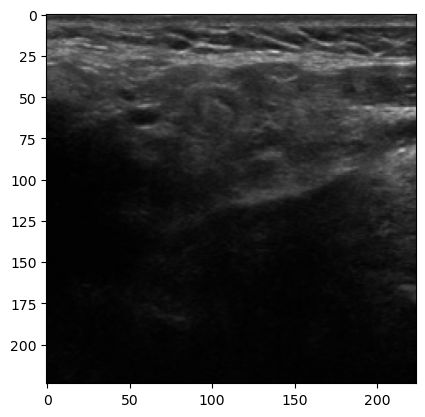

In [14]:
sample_img = transforms.functional.to_pil_image(img[0])
plt.imshow(sample_img)

In [15]:
import timm

class CustomModel(nn.Module):
    if CFG['MODEL'] == 1:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("resnet50", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x

    elif CFG['MODEL'] == 2:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("vgg16_bn", pretrained=True)
            self.model.head.fc = nn.Linear(in_features=4096, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x
        
    elif CFG['MODEL'] == 3:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("inception_v3", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [16]:
model = CustomModel().to(device)

In [17]:
def test_loop(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_control=[]
    label_control=[]
    pred_sjs=[]
    label_sjs=[]

    pred=[]
    label=[]

    for (X, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_control.append(t[1].detach().tolist())
            label_sjs.append(t[0].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output = model(X)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_control.append(o[1].detach().cpu().tolist())
            pred_sjs.append(o[0].detach().cpu().tolist())

    return label_control, label_sjs, pred_control, pred_sjs, np.array(label), np.array(pred)

In [18]:
label_control, label_sjs, pred_control, pred_sjs, label, pred = test_loop(test_dataloader, model, model_save_path)

In [19]:
test_control, test_sjs = 0, 0
for (X, y) in test_dataloader:
    for t in y:
        if t[1] == torch.Tensor([1]):
            test_control += 1
        else:
            test_sjs += 1

print(test_control)
print(test_sjs)

314
566


0.9864075183868408


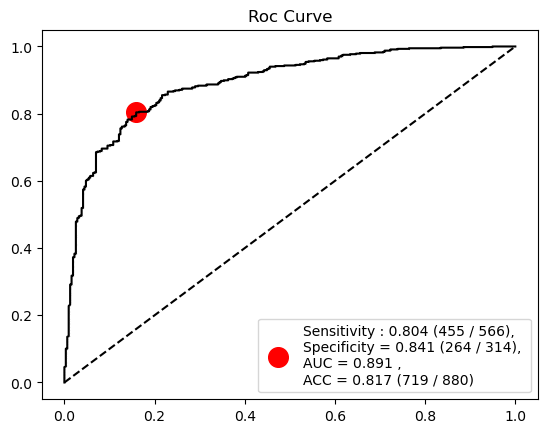

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(label_sjs, pred_sjs)

fpr, tpr, thresholds = roc_curve(label_sjs, pred_sjs)
J=tpr-fpr
idx = np.argmax(J)

best_thresh = thresholds[idx]
sens, spec = tpr[idx], 1-fpr[idx]
print(best_thresh)

acc = (sens*test_sjs + spec*test_control) / len(label_sjs)
auc = roc_auc_score(label_sjs, pred_sjs)

plt.title("Roc Curve")
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05)
plt.scatter(fpr[idx], tpr[idx], marker='o', s=200, color='r',
            label = 'Sensitivity : %.3f (%d / %d), \nSpecificity = %.3f (%d / %d), \nAUC = %.3f , \nACC = %.3f (%d / %d)' % (sens, (sens*test_sjs), test_sjs, spec, (spec*test_control), test_control, auc, acc, sens*test_sjs+spec*test_control, test_sjs+test_control))
plt.legend()

<Axes: >

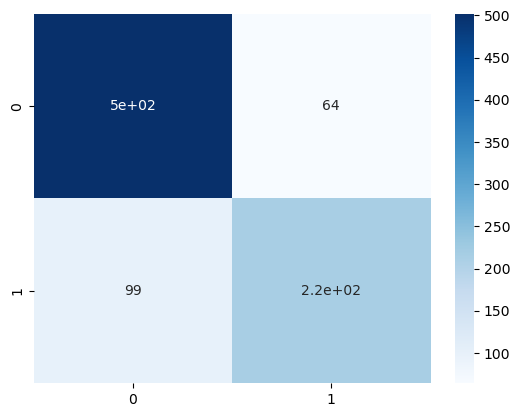

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

cm = confusion_matrix(OH_label, OH_pred)
plt.xlabel('Prediction')
plt.ylabel('Label')
sns.heatmap(cm, annot=True, cmap='Blues')